# <center>**Face Detection - MobileNet Transfer Learning**</center>
---
### **Project Description**
In this hands-on project, the goal is to build a face detection system which aims to locate the position of a face in an image.
### **Face Detector**
We will be using transfer learning on an already trained model to build our face detector. We will perform transfer learning on Mobile Net model which is already trained to perform object detection. We will need to train the last 6-7 layers and freeze the remaining layers to train the model for face detection. To be able to train the Mobile Net model for face detection, we will be using [WIDER FACE](http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/) dataset which already has the bounding box data for various images with single face and multiple faces. The output of the model is the bounding box data which gives the location of the face in an image. We learn to build a face detection model using Keras supported by Tensorflow.

In [0]:
# Installing the following exact versions of the packages to support the functions defined in mn_model.py
!pip install tensorflow==1.15.0
!pip install keras==2.2.4
!pip install scipy==1.2.1

### Imports and Configurations

In [2]:
import zipfile, sys, warnings, cv2
from math import ceil
import numpy as np
import scipy.misc as sm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
from termcolor import colored
from keras.preprocessing import image
from keras.optimizers import Adam, SGD, Nadam
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras import backend as K
from keras.models import load_model

Using TensorFlow backend.


In [3]:
# Set default configuration of some of the package
%pylab inline
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['ceil']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### In this problem we use "Transfer Learning" of an Object Detector model to detect any object according to the problem in hand.

Here, We are particularly interested in detecting faces in a given image.

#### To use the model first, we need to import the model and its supporting files for the model to function.

In [4]:
# Load the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Set files_zip_path to the location in the drive where you have the new `'Files_required_for_face_detection.zip'` file. This block will extract all the files to the current working directory. You should be seeing the list of all files inside the zip files as the output of this block after the final `!ls` command is executed. 

In [5]:
proj_path = "/content/drive/My Drive/Colab Notebooks/DLCP/FaceDetection-MobileNet/"
zip_file = "Files_required_for_face_detection.zip"

#This extracts the files to a new directory named MobileNet
archive = zipfile.ZipFile(proj_path + zip_file, 'r')
archive.extractall(proj_path + 'MobileNet/')

# Set the extracted folder to sys.path to be able to load the mn_model
sys.path.append(proj_path + 'MobileNet/')

# Also change the execution diretory to the extracted folder.
# We are going to extract the training and val images also to this folder
%cd $proj_path
%cd 'MobileNet/'

/content/drive/My Drive/Colab Notebooks/DLCP/FaceDetection-MobileNet
/content/drive/My Drive/Colab Notebooks/DLCP/FaceDetection-MobileNet/MobileNet


### Import MobileNet model given in file `mn_model.py`

In [0]:
### Import MobileNet model given in file `mn_model.py`
#Make sure you have the files required for face detection in the same folder as the code. If using Google Colabs upload
# them in the files section in the left panel 
from mn_model import mn_model

### Import the BatchGenerator and SSDLoss functions in given files `face_generator.py`, `keras_ssd_loss` and `ssd_box_encode_decode_utils.py` as well, used in MobileNet model

In [0]:
#### Import the BatchGenerator and SSDLoss functions as well, used in MobileNet model
# !pip install bs4 # use this if bs4 is not installed
from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2

## Set the parameters for the model

#### We need to customize the model parameters according to our problem as given below.

#### Set n_classes (no.of classes) = 2, as we are interested in only face detection. 
#### `Face` will be one class and everything else comes under other class (we can call it as `background`)

#### Set class_names = ["background", "face"]

In [0]:
img_height =512
img_width = 512

img_channels = 3

n_classes =2 
class_names = ["background","face"]

scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # anchorboxes for coco dataset
aspect_ratios = [[0.5, 1.0, 2.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [0.5, 1.0, 2.0],
                 [0.5, 1.0, 2.0]] # The anchor box aspect ratios used in the original SSD300
two_boxes_for_ar1 = True
limit_boxes = True # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = True

#Path where you want to save the weights, model and checkpoints
det_model_path = "weights/"
# Create te above path
%mkdir $det_model_path

### Now, we have imported the model and its dependencies. The next thing is to import the dataset for the model to train on. For this, we are using the WIDER FACE dataset. 

#### To make the dataset available follow the steps given below.


1. Create a folder in your google drive for this project. 

2. Download the train and test dataset files given in .zip format into your drive folder you created for the project in step-1.

3. Now, as we mount the drive the images will be available to use for training and testing but in zip format.

4. So, lets extract the images from the zipfiles by using the code given of zipfile module.







In [0]:
train_images_path = proj_path + 'WIDER_train.zip'
test_images_path = proj_path + 'WIDER_val.zip'

In [0]:
# This extracts the training images to the current working directory
archive = zipfile.ZipFile(train_images_path, 'r')
archive.extractall()

In [0]:
# This extracts the validation images to the current working directory
archive = zipfile.ZipFile(test_images_path, 'r')
archive.extractall()

### Now, the images are available. The next thing we need is to get the labels for these images, so that we can use this information while training for detecting faces with the given model using transfer learning. 

#### Follow the below steps to get those labels available.


Load the  '' `wider_train_small.npy`'' file given to check the information given about the dataset. In this file you can see the information about each image in the dataset in a list with following elemets:
      

        1.   Image filename (str)
        2.   Image filename (str)
        3.   Image size (list) [height, width]
        4.   List of bounding box co-ordinates and Class label (list) [[a,b,c,d], Class label, ...]
        
        where,
        a,b,c,d are the four co-ordinates of the bounding box
        Class label is the position of object as mentioned in `class_names` list above.

In [0]:
data = np.load('./wider_train_small.npy', allow_pickle=True).item()

In [13]:
### Printed first element to check the above given information.
# data contains lot of keys
for key in data:
    print(key)
    print(data[key])
    #Breaking after printing first key and its value
    break

52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg
['WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', 'WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', [300, 300], [[21, 667, 9, 655], 1]]


 As we can see from the above output all the information mentioned above is there for all the images.

### Now, load the files `wider_trian_v1.npy` and `wider_val_v1.npy`

In [0]:
train_data = 'wider_train_small.npy'
val_data = 'wider_val_small.npy'

### Now, call the imported model with the given parameters and freeze all the layers in the model with names not having ''`detection`'' word as prefix.

As we are not training the model from scratch, we are freezing all the above layers in the model having only last few layers while training to update their weights according to the problem in hand. This is called as **Transfer Learning**.

In [15]:
# build the keras model
# this model is not pre-trained, we are doing it from scratch 

K.clear_session()
#The following function returns you multiple things. The "model" is the Keras model that has to be trained 
model, model_layer, img_input, predictor_sizes = mn_model(image_size=(img_height, img_width, img_channels), 
                                                                      n_classes = n_classes,
                                                                      min_scale = None, 
                                                                      max_scale = None, 
                                                                      scales = scales, 
                                                                      aspect_ratios_global = None, 
                                                                      aspect_ratios_per_layer = aspect_ratios, 
                                                                      two_boxes_for_ar1= two_boxes_for_ar1, 
                                                                      limit_boxes=limit_boxes, 
                                                                      variances= variances, 
                                                                      coords=coords, 
                                                                      normalize_coords=normalize_coords)

model.summary()




====> Model Specific data
====> Height, Width, Channels : 512 512 3









__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda1 (Lambda)                (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda2 (Lambda)                (None, 512, 512, 3)  0           lambda1[0][0]                    
__________________________________________________________________________________________________
lambda3 (Lambda)                (None, 512, 512, 3)  0           lambda2[0][0]                    
_____________________________

#### Write code to freeze all the layers in the above model with names not having ''`detection`'' word as prefix.  - 5 Points

In [16]:
#Freeze classification layers
for layer in model_layer:
  model_layer[layer].trainable = layer.startswith('detection')
print(colored(f'Total {len([layer for layer in model_layer if model_layer[layer].trainable == False])} layers are freezed', 'green'))

Total 85 layers are freezed


### After making the model ready for transfer learning, load the weights of the model given in file ''`mobilenet_1_0_224_tf.h5`'' - 5 points
Note: You have to pass an extra parameter **'by_name=True'** to the load_weights function. This ensures that the weights are only loaded for the names present in both the weights file and the model. Otherwise You will get an error saying the number of weights in the file and the number of layers in the model as mismatched as your weightfile only consists of the weights needed. 

In [17]:
trained_weights = 'mobilenet_1_0_224_tf.h5'
model.load_weights(trained_weights, by_name=True)
print(colored('Weights loaded successfully', 'green'))

Weights loaded successfully


#### Using the functions given in the model, we are trying to divide the dataset into train and validation samples. Run the below code.

In [18]:
batch_size = 32
ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                predictor_sizes=predictor_sizes,
                                min_scale=None,
                                max_scale=None,
                                scales=scales,
                                aspect_ratios_global=None,
                                aspect_ratios_per_layer=aspect_ratios,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)

train_dataset = BatchGenerator(images_path=train_data, 
                include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==>TRAINING DATA")
print ("==> Parsing XML files ...")

train_dataset.parse_xml(
                  annotations_path=train_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)
print("==>Parsing XML Finished.")

print ("==>Generate training batches...")
train_generator = train_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=True,
                 brightness=(0.5,2,0.5),
                 flip=0.5,
                 translate=((0, 20), (0, 30), 0.5),
                 scale=(0.75, 1.2, 0.5),
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False,
                 resize=(img_height, img_width),
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print ("==>Training batch generation complete")

n_train_samples = train_dataset.get_n_samples()

print ("==>Total number of training samples = {}".format(n_train_samples))

# Now repeat above steps for validation data 

print ("\n==>VALIDATION")

val_dataset = BatchGenerator(images_path=val_data, include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==> Parsing XML files ...")


val_dataset.parse_xml(
                  annotations_path=val_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)


print("==>Parsing XML Finished.")


print ("==>Generate validation batches...")
val_generator = val_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False, 
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)


print ("==>Validation batch generation complete")

n_val_samples = val_dataset.get_n_samples()

print ("==>Total number of validation samples = {}".format(n_val_samples))

==>TRAINING DATA
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate training batches...
==>Training batch generation complete
==>Total number of training samples = 128

==>VALIDATION
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate validation batches...
==>Validation batch generation complete
==>Total number of validation samples = 60


### Now, lets setup things for training by initilaizing required variables like learning rate, epochs, optimizer and loss function(SSDLoss) to compile the model

In [19]:
# setting up training 

# batch_size and no.of epochs

batch_size = 16
num_epochs = 30

#Learning rate
base_lr = 0.002

# Optimizer
adam = Adam(lr=base_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-6, decay = 0.0)

# Loss
ssd_loss = SSDLoss(neg_pos_ratio=2, n_neg_min=0, alpha=1.0, beta = 1.0)

# Compile
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)



Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


### Lets add early stopping and model checkpoint layers on validation loss with some patience values and using fit_generator function to train the model on data generated batch-by-batch by a Python generator, `train_generator` object as generator.


We are using checkpoint to save the best model based on validation accuracy.

#### Write code for early_stopping and model_checkpoint layers. Using model.fit_generator train the model and save the best weight file. - 10 Points

In [20]:
# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=100)
model_checkpoint = ModelCheckpoint(det_model_path + 'MobileNet_FaceDetection.Model_epoch{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

# Train, Validate the model and save the best weights
print("Training on WIDER face data...")
model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_train_samples/batch_size)*2,
                              epochs = num_epochs,
                              callbacks = [model_checkpoint, early_stopping],                      
                              validation_data = val_generator,
                              validation_steps = ceil(n_val_samples/batch_size))

model.save_weights(det_model_path + 'MobileNet_FaceDetection.Weights_epoch{}.h5'.format(num_epochs))

print(colored("Model and best weights are saved at: " + det_model_path, 'green'))

Training on WIDER face data...


Epoch 1/30
16/16 [==============================] - 54s 3s/step - loss: 0.3209 - val_loss: 0.3243

Epoch 00001: val_loss improved from inf to 0.32429, saving model to weights/MobileNet_FaceDetection.Model_epoch01_loss0.3243.h5
Epoch 2/30
16/16 [==============================] - 15s 931ms/step - loss: 0.2485 - val_loss: 0.2776

Epoch 00002: val_loss improved from 0.32429 to 0.27758, saving model to weights/MobileNet_FaceDetection.Model_epoch02_loss0.2776.h5
Epoch 3/30
16/16 [==============================] - 34s 2s/step - loss: 0.2294 - val_loss: 0.2523

Epoch 00003: val_loss improved from 0.27758 to 0.25233, saving model to weights/MobileNet_FaceDetection.Model_epoch03_loss0.2523.h5
Epoch 4/30
16/16 [==============================] - 35s 2s/step - loss: 0.2180 - val_loss: 0.2399

Epoch 00004: val_loss improved from 0.25233 to 0.23994, saving model to weights/MobileNet_FaceDetection.Model_epoch04_loss0.2399.h5
Epoch 5/30
16/16 [==========================

### Check and load the best saved model with best Validation accuracy from above step and check predictions for test data using test_generator object to generate batches. 

#### Write code in the below cell to load best saved model in the above step.  - 5 Points

In [21]:
best_saved_model = 'ssd_mobilenet_face_epoch_25_loss0.0916.h5'
model.load_weights(best_saved_model,  by_name= True)

print(colored('weights %s loaded' % (best_saved_model), 'green'))

weights ssd_mobilenet_face_epoch_25_loss0.0916.h5 loaded


### Use the below function to plot the boundingbox in the test image to show the predictions.

In [0]:
def save_bb(path, filename, results, prediction=True):
  
  # print filename

  img = image.load_img(filename, target_size=(img_height, img_width))
  img = image.img_to_array(img)

  filename = filename.split("/")[-1]

  if(not prediction):
    filename = filename[:-4] + "_gt" + ".jpg"

  #fig,currentAxis = plt.subplots(1)
  currentAxis = plt.gca()

 # Get detections with confidence higher than 0.6.
  colors = plt.cm.hsv(np.linspace(0, 1, len(results))).tolist()
  color_code = len(results)
  print (colored("total number of bbs: %d" % len(results), "yellow"))
  for result in results:
    # Parse the outputs.

    if(prediction):
      det_label = result[0]
      det_conf = result[1]
      det_xmin = result[2]
      det_xmax = result[3]
      det_ymin = result[4]
      det_ymax = result[5]
    else :
      det_label = result[0]
      det_xmin = result[1]
      det_xmax = result[2]
      det_ymin = result[3]
      det_ymax = result[4]

    xmin = int(det_xmin)
    ymin = int(det_ymin)
    xmax = int(det_xmax)
    ymax = int(det_ymax)

    if(prediction):
      score = det_conf
    
    plt.imshow(img / 255.)
    
    label = int(int(det_label))
    label_name = class_names[label]
    # print label_name 
    # print label

    if(prediction):
      display_txt = '{:0.2f}'.format(score)
    else:
      display_txt = '{}'.format(label_name)

      
    # print (xmin, ymin, ymin, ymax)
    coords = (xmin, ymin), (xmax-xmin), (ymax-ymin)
    color_code = color_code-1 
    color = colors[color_code]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.2})

  # y
  currentAxis.axes.get_yaxis().set_visible(False)
  # x
  currentAxis.axes.get_xaxis().set_visible(False)
  plt.savefig(path + filename, bbox_inches='tight')

  print ('saved' , path + filename)

  plt.clf()

#### Run the below code to create a folder with name output_test and get the predictions for the test images using model.predict()

In [0]:
%mkdir output_test

In [24]:
val_size = 16
test_generator = val_dataset.generate(
                 batch_size=val_size,
                 train=False,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print (colored("done.", "green"))

print (colored("now predicting...", "yellow"))

_CONF = 0.60 
_IOU = 0.15

for j in range(val_size):
  X, y, filenames = next(test_generator)
  num_files = len(filenames)

  y_pred = model.predict(X)


  y_pred_decoded = decode_y2(y_pred,
                            confidence_thresh=_CONF,
                            iou_threshold=_IOU,
                            top_k='all',
                            input_coords=coords,
                            normalize_coords=normalize_coords,
                            img_height=img_height,
                            img_width=img_width)


  np.set_printoptions(suppress=True)
  
  for i in range(num_files):
    save_bb("./output_test/", filenames[i], y_pred_decoded[i])
    save_bb("./output_test/", filenames[i], y[i], prediction=False)

done.
now predicting...
total number of bbs: 5
saved ./output_test/2_Demonstration_Protesters_2_646.jpg
total number of bbs: 14
saved ./output_test/2_Demonstration_Protesters_2_646_gt.jpg
total number of bbs: 3
saved ./output_test/2_Demonstration_Demonstrators_2_188.jpg
total number of bbs: 12
saved ./output_test/2_Demonstration_Demonstrators_2_188_gt.jpg
total number of bbs: 1
saved ./output_test/33_Running_Running_33_209.jpg
total number of bbs: 1
saved ./output_test/33_Running_Running_33_209_gt.jpg
total number of bbs: 1
saved ./output_test/39_Ice_Skating_Ice_Skating_39_270.jpg
total number of bbs: 1
saved ./output_test/39_Ice_Skating_Ice_Skating_39_270_gt.jpg
total number of bbs: 0
saved ./output_test/33_Running_Running_33_475.jpg
total number of bbs: 1
saved ./output_test/33_Running_Running_33_475_gt.jpg
total number of bbs: 6
saved ./output_test/12_Group_Large_Group_12_Group_Large_Group_12_448.jpg
total number of bbs: 5
saved ./output_test/12_Group_Large_Group_12_Group_Large_Grou

In the above step all the test images along with predictions are stored in output_test folder in this notebook environment. You can check the folder in Files section of the menu to left-side of screen in colab.

Each test image is used for predictions and is stored as 2 files.

one file is the original ground truth with <filename_gt.jpg>
second file is the prediction of the model on the image. with <filename.jpg>

### Visualize a test image to check predictions


#### Write code to show images: Using cv2.imread() to read the output images created above and matplotlib to show any 3 test images and their predictions. The outputs of test images are present in the './output_test/' folder - 5 Points

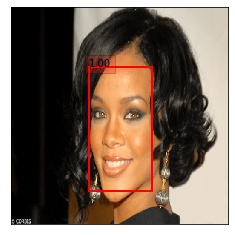

In [25]:
from google.colab.patches import cv2_imshow
img = cv2.imread('output_test/13_Interview_Interview_Sequences_13_779.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

Populating the interactive namespace from numpy and matplotlib


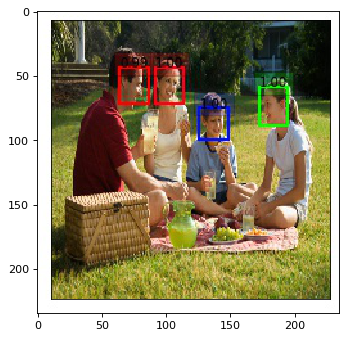

In [27]:
%pylab inline
img=mpimg.imread('output_test/22_Picnic_Picnic_22_10.jpg')
figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
imgplot = plt.imshow(img)
plt.show()